In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
sns.set()

# yvr, yvrCases
# %store -r

In [4]:
#Build NA covid data for all airport comparisons
# Build total + new NA cases
NaData = pd.read_csv("Archieved-Data/casesNA.csv", compression = 'gzip')
NaData["Date"] = pd.to_datetime(NaData["Date"])
NaSums = NaData.groupby(NaData['Date']).sum().reset_index()
naCases = NaSums[['Date','Confirmed']]
temp = naCases.shift(1)
naCases['New'] = naCases['Confirmed'] - temp['Confirmed']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
 naCases.loc[0,"New"] = 0
from statsmodels.nonparametric.smoothers_lowess import lowess
new_cases_smooth = lowess(naCases['New'], naCases["Date"], frac =0.05)
confirm_smooth = lowess(naCases['Confirmed'], naCases["Date"], frac =0.05)
naCases['New_smooth'] = new_cases_smooth[:,1]
naCases['Confirm_smooth'] = confirm_smooth[:,1]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

# YVR

In [6]:
yvr = pd.read_csv('yvr4analyze_both.csv')
yvrCases = pd.read_csv('Covid-Data/yvr-modified.csv')

# For some reason, the "Date" column wasn't being interpeted by the parsing arguments through input
# Or in pd.to_csv(). So we need to reformat it into datetime type when we reimport it
# It wasn't an issue when it was indirectly referenced via %store so maybe converting it csv 
# wiped out something?

yvr["Date"] = pd.to_datetime(yvr["Date"])
yvrCases["Date"] = pd.to_datetime(yvrCases["Date"])

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


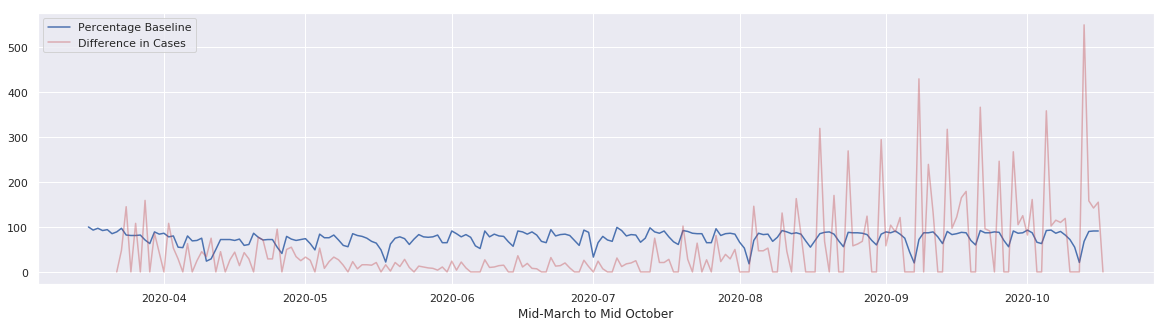

In [7]:
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yvrCases["Date"], yvrCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

Date                 208
Difference           208
Confirmed            208
Diff_smooth          208
PercentOfBaseline    208
Baseline_smooth      208
dtype: int64


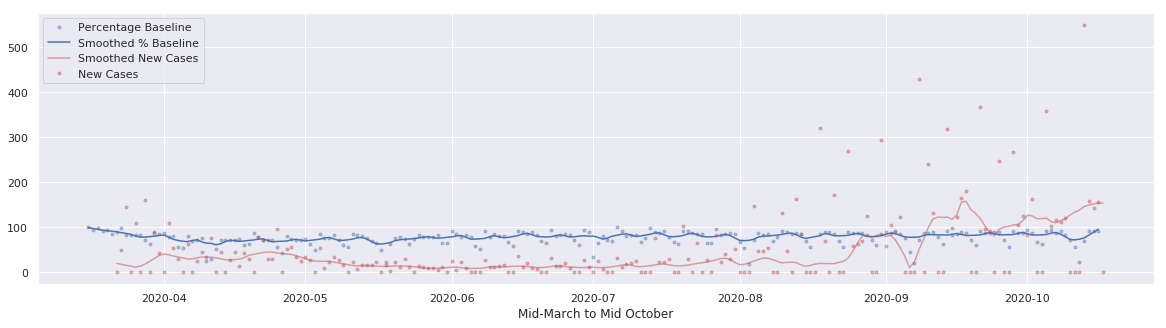

In [8]:
# We see that new cases per day is 0 sometimes, which isn't actually true, just that maybe
# the cases found for a couple of days aren't logged that day, but instead logged on another day, so we should
# smooth the new cases over a couple of days
# We also want to smooth out the weekly cycles in the data to see the long-run correlations
new_cases_smooth = lowess(yvrCases['Difference'], yvrCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yvr['PercentOfBaseline'], yvr["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yvrCases['Diff_smooth'] = new_cases_smooth[:,1]
yvr['Baseline_smooth'] = baseline_smooth[:,1]
# This is to make sure both yvr and yvrCases start and end on the same dates
if (yvr.count().loc['Date'] != yvrCases.count().loc['Date']):
    joined = yvrCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yvr[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yvrCases["Diff_smooth"]
    y = yvr["Baseline_smooth"]

print(joined.count())
#can use X,y or original, doesn't really matter
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yvr["Date"], yvr['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yvrCases["Date"], yvrCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

0.3320289080751596


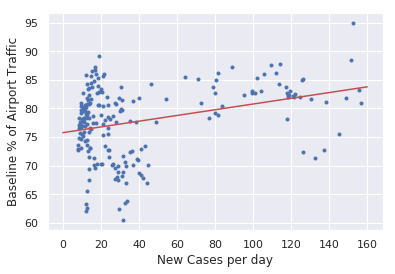

In [9]:
# Is there statistical correlation between the two values- Baseline, and New Cases?
# We use smoothed versions of data because don't want to analyze the weekly noise (tho holidays still exist)
# y = Diff
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)
print(regression.rvalue)
linearX = np.linspace(0,160)
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')
#Data, especially X is unbalanced really. The r-value is too low to indicate some sort of relation between
# the two pieces of data

0.48263389848560434


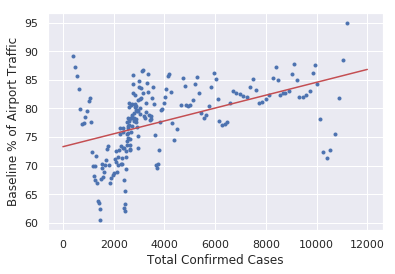

In [10]:
# What about confirmed?
#smooth it, and then plot it
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')
reg = stats.linregress(confirmX, y)
print(reg.rvalue)
linearX = np.linspace(0,12000)
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')
# slightly better but still terrible. Though interesting to see that consistent dip in airport traffic when the 
# total was around 2000 this was probably due to the inital shock in the early parts of the pandemic

0.6453761451885414
0.424880390045968


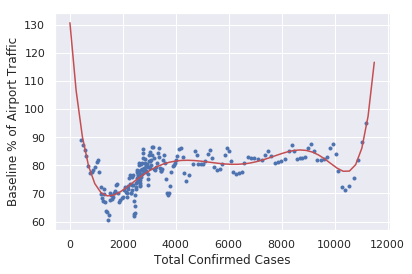

In [11]:
# It doesn't seem like linear regression is what we want, let's try a polynomial
# The data shows 2 dips --> matches with knowledge of the two waves
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

X = np.stack([confirmX], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,y)

poly_regress = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=8, include_bias = True),
    LinearRegression(fit_intercept = False))
poly_regress.fit(X_train, y_train)

linearX = np.stack([np.linspace(0,11500)],axis=1)

plt.plot(linearX, poly_regress.predict(linearX), 'r-')
print(poly_regress.score(X_train,y_train))
print(poly_regress.score(X_valid,y_valid))
# Oh hey we get something pretty good, but with poly regression, we can't exactly 
# predict into the future

-0.46930236971963796
-0.9176082647508534


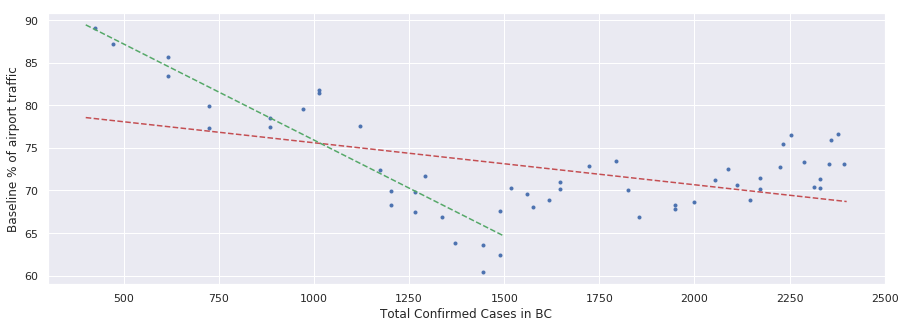

In [12]:
# Analyzing statistical correlation in --> full first wave
first_wave = joined[joined['Date']<'2020-05-15']
plt.figure(figsize = (15,5))

"""plt.plot(first_wave["Date"], first_wave['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.7)
plt.plot(first_wave["Date"], first_wave['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(first_wave["Date"], first_wave["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(first_wave["Date"], first_wave['Difference'], 'r.', label = 'New Cases', alpha = 0.7)
plt.xlabel("Mid-March to Mid-May: First Wave")
plt.legend()
plt.show() #two things over time"""

plt.plot(first_wave["Confirmed"],first_wave["Baseline_smooth"], 'b.')
plt.xlabel("Total Confirmed Cases in BC")
plt.ylabel("Baseline % of airport traffic")

regression = stats.linregress(first_wave["Confirmed"], first_wave["Baseline_smooth"])
print(regression.rvalue)

linearX = np.linspace(400,2400)
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--')

# We can clearly see that while there was a huge decrease in airport traffic in the 
# beginning, but it recovered over time back to the new normal
# how about when we try to only look at the first 25 days? 
reg2 = stats.linregress(first_wave["Confirmed"].head(25), first_wave["Baseline_smooth"].head(25))
print(reg2.rvalue)
lin2 = np.linspace(400,1500)
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--')
# get rvalue showing there is indeed a close linear correlation in the first 'shock'
# but later on, no longer the same correlation

Text(0, 0.5, 'Baseline Smoothed')

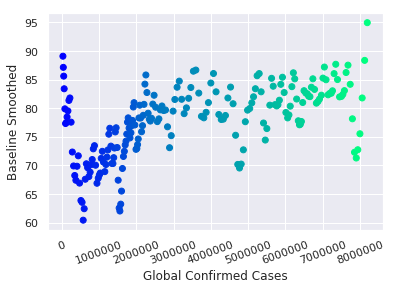

In [13]:
# This is to make sure both yvr and naCases start and end on the same dates
if (yvr.count().loc['Date'] != naCases.count().loc['Date']):
    joined = naCases[["Date","Confirmed","New"]].join(yvr[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()

plt.scatter(joined['Confirmed'],joined['Baseline_smooth'],c=joined['Date'],cmap='winter' )
plt.xlabel("Global Confirmed Cases")
plt.xticks(rotation=20)
plt.ylabel("Baseline Smoothed")

In [14]:
# Machine Learning regression
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split 
#should prob comment these three above bc already imported
"""from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
X_train,X_valid,y_train,y_valid = train_test_split(X,y)
knmodel = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor(5)
    )
knmodel.fit(X_train, y_train)
rfmodel = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(50, max_depth=5)
    )
rfmodel.fit(X_train, y_train)
nnmodel = make_pipeline(
    MinMaxScaler(),
    MLPRegressor(hidden_layer_sizes = (10,10,5), 
                 activation='logistic', solver='lbfgs')
    )
nnmodel.fit(X_train, y_train)"""

# GB regressor does the best out of all of them bc diff factors are weighed differently
# Also not that much data, so neural network doesn't really work
gbmodel = make_pipeline(
    MinMaxScaler(),
    GradientBoostingRegressor(n_estimators=50, max_depth=5)
    )
gbmodel.fit(X_train, y_train)

#linearX = np.stack([np.linspace(0,11500)],axis=1)
#plt.plot(linearX, poly_regress.predict(linearX), 'r-')
#print(knmodel.score(X_train,y_train), knmodel.score(X_valid,y_valid))
#print(rfmodel.score(X_train,y_train), rfmodel.score(X_valid,y_valid))
#print(nnmodel.score(X_train,y_train), nnmodel.score(X_valid,y_valid))
print(gbmodel.score(X_train,y_train), gbmodel.score(X_valid,y_valid))

0.972782365448942 0.7953880525308381


In [15]:
temp = yvr.shift(-1)
temp["PercentOfBaseline"] = temp["PercentOfBaseline"]

X = np.array(yvr['PercentOfBaseline'].head(100)).reshape(-1, 1)
y = np.array(temp["PercentOfBaseline"].head(100)).astype(int).reshape(-1, 1)

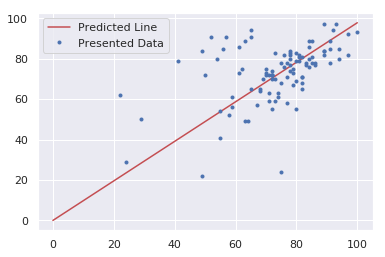

In [16]:
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
linearX = np.linspace(0,100).reshape(-1,1) #maybe change params
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()

# YEG

In [17]:
yeg = pd.read_csv('yeg4analyze_both.csv',index_col =0, parse_dates = [1])
yegCases = pd.read_csv('Covid-Data/yeg-modified.csv', index_col =0, parse_dates = [5])

yeg["Date"] = pd.to_datetime(yeg["Date"])
yegCases["Date"] = pd.to_datetime(yegCases["Date"])

yegCases.loc[0, "Difference"] = 0

In [18]:
#yegCases

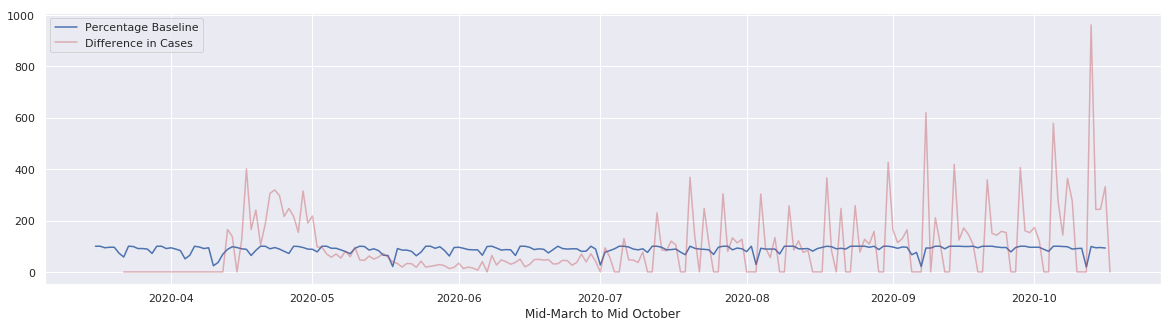

In [19]:
plt.figure(figsize = (20,5))
plt.plot(yeg["Date"], yeg['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yegCases["Date"], yegCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yegCases["Date"], yegCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

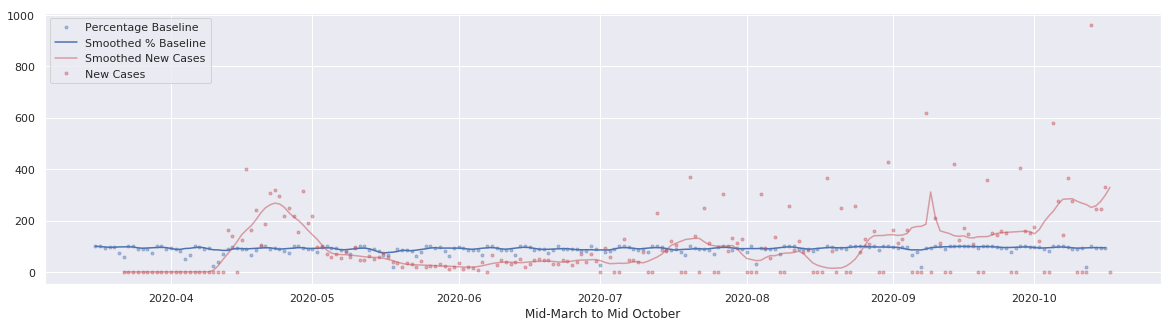

In [29]:
# Small curve in initial phase (Mid-Apr), flattened down shortly after 
# Steep increases after the Summer - look for causes 
# Called in military to assist with rising cases; lockdown
# % Baseline didn't change dramatically (decrease in business trips and international travel)
# Small dips

new_cases_smooth = lowess(yegCases['Difference'], yegCases["timestamp"], frac =0.05)
#to reduce weekly cycle effect 7/214 = 0.327
baseline_smooth = lowess(yeg['PercentOfBaseline'], yeg["Date"], frac =0.04) 
yegCases['Diff_smooth'] = new_cases_smooth[:,1]
yegCases['Diff_smooth'] = new_cases_smooth[:,1]
yeg['Baseline_smooth'] = baseline_smooth[:,1]

# Ensure both yeg and yegCases start and end on the same dates
if (yeg.count().loc['Date'] != yegCases.count().loc['Date']):
    joined = yegCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yeg[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yegCases["Diff_smooth"]
    y = yeg["Baseline_smooth"]

plt.figure(figsize = (20,5))
plt.plot(yeg["Date"], yeg['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yeg["Date"], yeg['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yegCases["Date"], yegCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yegCases["Date"], yegCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

0.2578346846082401


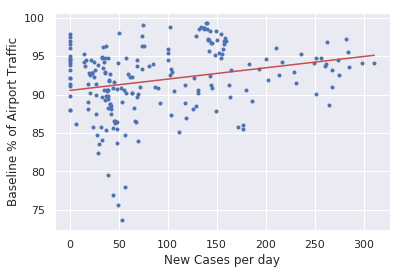

In [30]:
# Find statistical correlation between the two values- Baseline, and New Cases, using the filtered data from above
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)

print(regression.rvalue)

# 311 = max(X)
linearX = np.linspace(0, max(X)) 
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')

# r-value: Slight but negligible correlation 
# imbalanced data??

0.37694935879079305


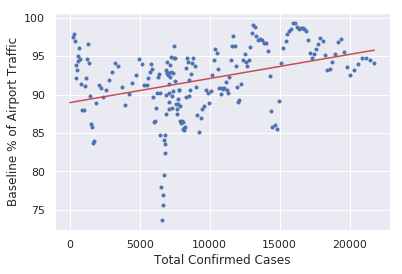

In [31]:
# Repeat for Number of Confirmed Patients
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04)
# to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

reg = stats.linregress(confirmX, y)

print(reg.rvalue)

linearX = np.linspace(0, max(confirmX)) 
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')

# r-value: slight positive correlation 

In [23]:
'''
temp = yeg.shift(-1)

# the last val of temp is NaN so omit the last element of both X and y to ensure equal array sizes
X = np.array(yeg['PercentOfBaseline'].head(len(X) - 1)).reshape(-1, 1)
y = np.array(temp["PercentOfBaseline"].head(len(y) - 1)).astype(int).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y)
'''

'\ntemp = yeg.shift(-1)\n\n# the last val of temp is NaN so omit the last element of both X and y to ensure equal array sizes\nX = np.array(yeg[\'PercentOfBaseline\'].head(len(X) - 1)).reshape(-1, 1)\ny = np.array(temp["PercentOfBaseline"].head(len(y) - 1)).astype(int).reshape(-1, 1)\n\nX_train, X_valid, y_train, y_valid = train_test_split(X, y)\n'

In [55]:
# plt.hist(confirmX)
# Pretty hopeless, can't seem to transform this 

In [80]:
'''
model = LinearRegression(fit_intercept = False)
model.fit(X_train, y_train)
linearX = np.linspace(0,100).reshape(-1, 1) #maybe change params
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()

# TODO: Fix
print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))
'''

X = np.stack([confirmX], axis =1)
X_train,X_valid,y_train,y_valid = train_test_split(X,y)

0.9157061693837549
0.8406091946388933


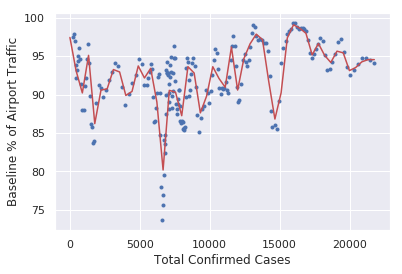

In [81]:
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

poly_regress = make_pipeline(
    MinMaxScaler(),
    #PolynomialFeatures(degree=2, include_bias = True),
    #LinearRegression(fit_intercept = False)
    KNeighborsRegressor(3)
)
poly_regress.fit(X_train, y_train)

linearX = np.stack([np.linspace(0,max(confirmX))],axis=1)
plt.plot(linearX, poly_regress.predict(linearX), 'r-')

# Hmmm... not too bad. Could be smoothed out more
print(poly_regress.score(X_train,y_train))
print(poly_regress.score(X_valid,y_valid))

In [297]:
'''
temp = yegCases.shift(-1)

# the last val of temp is NaN so omit the last element of both X and y to ensure equal array sizes
X = np.array(yegCases['Difference'].head(len(X) - 1)).reshape(-1, 1)
y = np.array(temp["Difference"].head(len(y) - 1)).astype(int).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y)
'''

-0.43134614735419413
-0.055467779114738484
-0.550641316276048


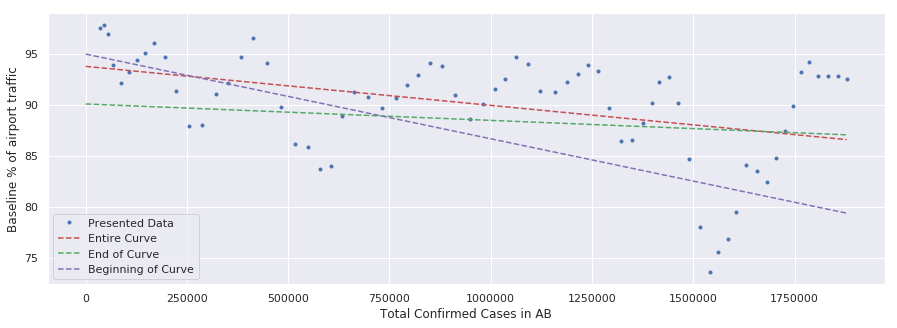

In [90]:
# Analyzing statistical correlation in --> Wave 1
first_wave = joined[joined['Date']<'2020-06-01']
plt.figure(figsize = (15,5))

"""plt.plot(first_wave["Date"], first_wave['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.7)
plt.plot(first_wave["Date"], first_wave['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(first_wave["Date"], first_wave["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(first_wave["Date"], first_wave['Difference'], 'r.', label = 'New Cases', alpha = 0.7)
plt.xlabel("Mid-March to Mid-May: First Wave")
plt.legend()
plt.show() #two things over time"""

plt.plot(first_wave["Confirmed"],first_wave["Baseline_smooth"], 'b.', label = 'Presented Data')
plt.xlabel("Total Confirmed Cases in AB")
plt.ylabel("Baseline % of airport traffic")

regression = stats.linregress(first_wave["Confirmed"], first_wave["Baseline_smooth"])
print(regression.rvalue)
# weak correlation
linearX = np.linspace(400, max(first_wave["Confirmed"]))
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--', label = 'Entire Curve')

# Analyze the tail of the first wave: The last 30 days 
# i.e. when it tapered down in May
reg2 = stats.linregress(first_wave["Confirmed"].tail(30), first_wave["Baseline_smooth"].tail(30))
print(reg2.rvalue)
# No correlation
lin2 = np.linspace(400, max(first_wave["Confirmed"]))
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--', label = 'End of Curve')

# Analyze the first month the curve: the month where it kept climbing up
reg3 = stats.linregress(first_wave["Confirmed"].head(30), first_wave["Baseline_smooth"].head(30))
print(reg3.rvalue)
# Moderate correlation
lin3 = np.linspace(400, max(first_wave["Confirmed"]))
plt.plot(lin3, reg3.slope*lin3+ reg3.intercept,'m--', label = 'Beginning of Curve')
plt.legend()

Text(0, 0.5, 'Baseline Smoothed')

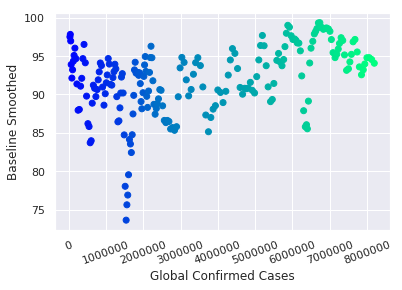

In [44]:
# This is to make sure both yeg and naCases start and end on the same dates
if (yeg.count().loc['Date'] != naCases.count().loc['Date']):
    joined = naCases[["Date","Confirmed","New"]].join(yeg[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()

# How to interpret?
plt.scatter(joined['Confirmed'],joined['Baseline_smooth'],c=joined['Date'],cmap='winter' )
# Should be just NA?
plt.xlabel("NA Confirmed Cases")
plt.xticks(rotation=20)
plt.ylabel("Baseline Smoothed")

In [49]:
'''
def sqrt_fx(X):
    one = np.ones(X.shape)
    sq_rt = np.sqrt(X)
    return np.concatenate((one, X, sq_rt), axis=1)

model = make_pipeline(
    FunctionTransformer(sqrt_fx, validate=True),
    #LinearRegression(fit_intercept=False),
    RandomForestRegressor(30, max_depth=4)
)
model.fit(X_train, y_train)

linearX = np.linspace(0,max(X)).reshape(-1, 1) 
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()

print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))
'''

'\ndef sqrt_fx(X):\n    one = np.ones(X.shape)\n    sq_rt = np.sqrt(X)\n    return np.concatenate((one, X, sq_rt), axis=1)\n\nmodel = make_pipeline(\n    FunctionTransformer(sqrt_fx, validate=True),\n    #LinearRegression(fit_intercept=False),\n    RandomForestRegressor(30, max_depth=4)\n)\nmodel.fit(X_train, y_train)\n\nlinearX = np.linspace(0,max(X)).reshape(-1, 1) \nplt.plot(linearX, model.predict(linearX), \'r-\', label = "Predicted Line")\nplt.plot(X, y, \'b.\', label = \'Presented Data\')\nplt.legend()\n\nprint(model.score(X_train, y_train))\nprint(model.score(X_valid, y_valid))\n'

In [52]:
# ML with new cases, total cases, na cases: total + new, vs y= Baseline
#naCases --> Confirmed, New, New_smooth, Confirm_smooth
#joined --> Confirmed, Confirmed_smooth, Difference, Diff_smooth, Baseline_smooth, PercentOfBaseline
'''
joined["Confirmed_smooth"] = confirmX

# X --> na_confirm, na_new, bc_confirm, bc_new
X = naCases[["Confirm_smooth", "New_smooth", "Date"]].join(joined[["Confirmed_smooth","Diff_smooth","Date"]].set_index('Date'), on ='Date')
X = X.rename(columns={"Confirm_smooth": "na_confirm", "New_smooth":"na_new", "Confirmed_smooth":"ab_confirm", "Diff_smooth":"bc_new"})
X = X[["na_confirm","na_new","bc_confirm","bc_new"]].dropna()

# y --> joined['Baseline_smooth']
y = joined['Baseline_smooth'].rename(columns={"Baseline_smooth":"yegBaseline"})
'''

'\njoined["Confirmed_smooth"] = confirmX\n\n# X --> na_confirm, na_new, bc_confirm, bc_new\nX = naCases[["Confirm_smooth", "New_smooth", "Date"]].join(joined[["Confirmed_smooth","Diff_smooth","Date"]].set_index(\'Date\'), on =\'Date\')\nX = X.rename(columns={"Confirm_smooth": "na_confirm", "New_smooth":"na_new", "Confirmed_smooth":"ab_confirm", "Diff_smooth":"bc_new"})\nX = X[["na_confirm","na_new","bc_confirm","bc_new"]].dropna()\n\n# y --> joined[\'Baseline_smooth\']\ny = joined[\'Baseline_smooth\'].rename(columns={"Baseline_smooth":"yegBaseline"})\n'

0.9636483266140413 0.8366725030063873


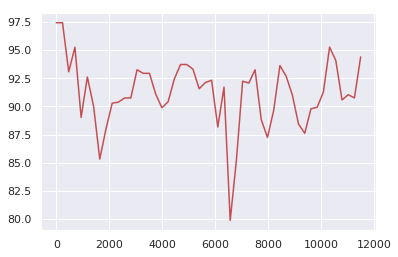

In [91]:
# Machine Learning regression

"""
X_train,X_valid,y_train,y_valid = train_test_split(X,y)
knmodel = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor(5)
    )
knmodel.fit(X_train, y_train)
rfmodel = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(50, max_depth=5)
    )
rfmodel.fit(X_train, y_train)
nnmodel = make_pipeline(
    MinMaxScaler(),
    MLPRegressor(hidden_layer_sizes = (10,10,5), 
                 activation='logistic', solver='lbfgs')
    )
nnmodel.fit(X_train, y_train)"""

# GB regressor does the best out of all of them bc diff factors are weighed differently
# Also not that much data, so neural network doesn't really work
gbmodel = make_pipeline(
    MinMaxScaler(),
    GradientBoostingRegressor(n_estimators=50, max_depth=5)
    )
gbmodel.fit(X_train, y_train)

linearX = np.stack([np.linspace(0,11500)],axis=1)
plt.plot(linearX, poly_regress.predict(linearX), 'r-')
#print(knmodel.score(X_train,y_train), knmodel.score(X_valid,y_valid))
#print(rfmodel.score(X_train,y_train), rfmodel.score(X_valid,y_valid))
#print(nnmodel.score(X_train,y_train), nnmodel.score(X_valid,y_valid))
print(gbmodel.score(X_train,y_train), gbmodel.score(X_valid,y_valid))

# YUL

In [19]:
yul = pd.read_csv('yul4analyze_both.csv',index_col =0, parse_dates = [1])
yulCases = pd.read_csv('Covid-Data/yul-modified.csv', index_col =0, parse_dates = [5])

yul["Date"] = pd.to_datetime(yul["Date"])
yulCases["Date"] = pd.to_datetime(yulCases["Date"])

yulCases.loc[0, "Difference"] = 0

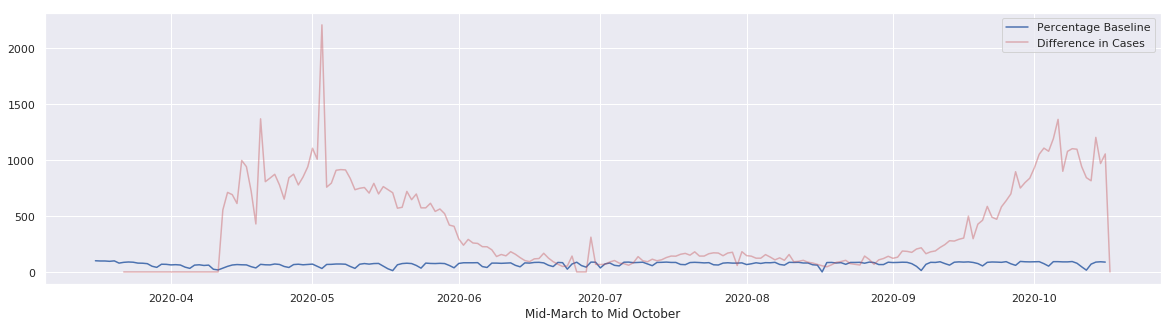

In [20]:
# Well thats a funky looking plot.

plt.figure(figsize = (20,5))
plt.plot(yul["Date"], yul['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yulCases["Date"], yulCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yulCases["Date"], yulCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

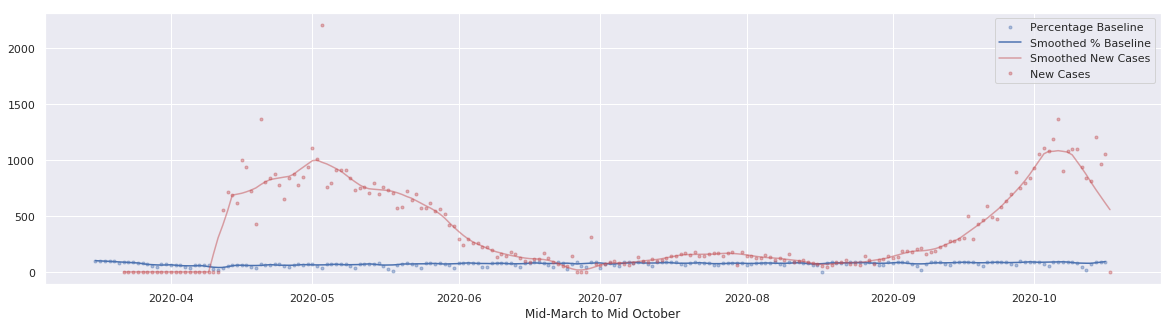

In [21]:
# baseline seems constant; except for the small dip in March
# Find factors to attribute to the two curves - small bump in the summer?
# The second one might be an instance to not increase flights to YUL
# lots of 0s in the beginning.... averaging or imputing the missing values might have been a good idea

new_cases_smooth = lowess(yulCases['Difference'], yulCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yul['PercentOfBaseline'], yul["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yulCases['Diff_smooth'] = new_cases_smooth[:,1]
yul['Baseline_smooth'] = baseline_smooth[:,1]
# Ensure both yul and yulCases start and end on the same dates
if (yul.count().loc['Date'] != yulCases.count().loc['Date']):
    joined = yulCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yul[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yulCases["Diff_smooth"]
    y = yul["Baseline_smooth"]

plt.figure(figsize = (20,5))
plt.plot(yul["Date"], yul['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yul["Date"], yul['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yulCases["Date"], yulCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yulCases["Date"], yulCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

-0.10402831009506958


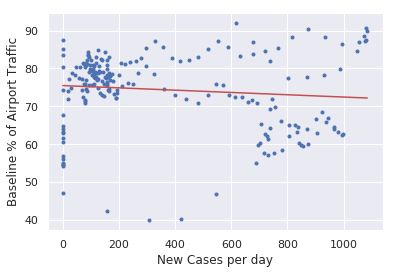

In [22]:
# Find statistical correlation between the two values- Baseline, and New Cases, using the filtered data from above

plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)

print(regression.rvalue)

linearX = np.linspace(0, max(X)) 
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')

# neglible correlation. so assume none at all - look into possible factors
# are people still travelling, or not travelling?

0.7736308232381549


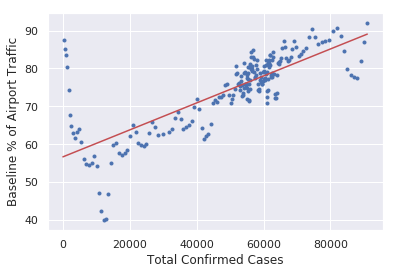

In [23]:
# Repeat for Number of Confirmed Patients
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04)
# to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

reg = stats.linregress(confirmX, y)

print(reg.rvalue)

linearX = np.linspace(0, max(confirmX)) 
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')

# this is pretty interesting - strong indication of positive correlation

In [277]:
temp = yul.shift(-1)


# the last val of temp is NaN so omit the last element of both X and y to ensure equal array sizes
X = np.array(yul['PercentOfBaseline'].head(len(X) - 1)).reshape(-1, 1)
y = np.array(temp["PercentOfBaseline"].head(len(y) - 1)).astype(int).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

(array([ 8., 12., 14., 20., 30., 25., 34., 46., 11.,  5.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <a list of 10 Patch objects>)

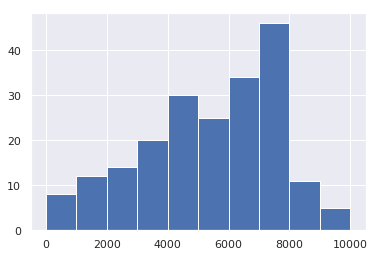

In [278]:
# Very right skewed
plt.hist(X ** 2)

0.32915272878226387
0.13783026953459865


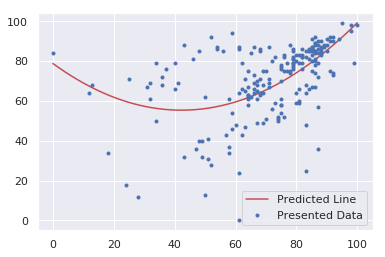

In [281]:
model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=True),
    LinearRegression(fit_intercept=False)
)

model.fit(X_train, y_train)

linearX = np.linspace(0,max(X_train)).reshape(-1, 1) #maybe change params
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()

print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))

# Is this the best that we can get it to?
# Needs fixing

In [283]:
temp = yulCases.shift(-1)

# the last val of temp is NaN so omit the last element of both X and y to ensure equal array sizes
X = np.array(yulCases['Difference'].head(len(X) - 1)).reshape(-1, 1)
y = np.array(temp["Difference"].head(len(y) - 1)).astype(int).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

(array([24., 22., 67., 17., 10., 33., 23.,  7.,  0.,  1.]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ]),
 <a list of 10 Patch objects>)

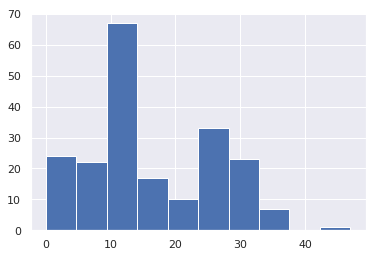

In [289]:
# Can't seem to get it into normal dist
plt.hist(X ** 0.5)

0.7613810249051673
0.8980257021779577


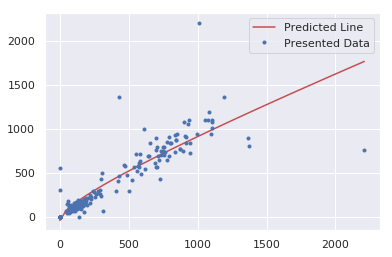

In [295]:
def sqrt_fx(X):
    one = np.ones(X.shape)
    sq_rt = np.sqrt(X)
    return np.concatenate((one, X, sq_rt), axis=1)

model = make_pipeline(
    #PolynomialFeatures(degree=2, include_bias=True),
    FunctionTransformer(sqrt_fx, validate = True),
    LinearRegression(fit_intercept=False)
)
model.fit(X_train, y_train)

linearX = np.linspace(0,max(X)).reshape(-1, 1) 
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()

print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))